In [2]:
#Load packages
from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4
from torch import nn
from torch import optim
import progressbar
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import transforms
from torch import nn
from torch import optim
import progressbar
sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")
import torch
from torch.utils.data import DataLoader, Dataset
from variables import index_training_start,index_training_end,index_validation_start,index_validation_end

In [3]:
# LOAD ALL THE RAW IMAGES 

def load_raw_images():

    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/image_inputs/inputs_date_000000_006480.nc','r')
    temperature = np.asfortranarray(nc.variables['temperature'])
    vorticity = np.asfortranarray(nc.variables['vorticity'])
    u = np.asfortranarray(nc.variables['u'])
    v = np.asfortranarray(nc.variables['v'])
    ssh = np.asfortranarray(nc.variables['ssh'])
    nc.close()

    temperature = np.transpose(temperature, (3, 2, 0,1))
    vorticity = np.transpose(vorticity, (3, 2, 0,1))
    u = np.transpose(u, (3, 2, 0,1))
    v = np.transpose(v, (3, 2, 0,1))
    ssh = np.transpose(ssh, (2, 0, 1))
    ssh = ssh[:, np.newaxis, :, :]

    return(temperature,vorticity,u,v,ssh)

def load_pdf():
    
    ncfile = 'pdf_8_levels_dt_0000_0107_100dx.nc'
    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/pdf/{0}'.format(ncfile),'r')
    pdf = np.asfortranarray(nc.variables['pdf'])
    nc.close()
    
    return(pdf)

def load_pdf_filter():
    
    ncfile = 'filter_pdf_8_levels_dt_0000_0107_100dx.nc'
    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/pdf/{0}'.format(ncfile),'r')
    pdf_filter = np.asfortranarray(nc.variables['pdf_filter'])
    nc.close()
    
    return(pdf_filter)

def load_pdf_train():
    
    ncfile = 'pdf_8_levels_dt_0000_0107_100dx.nc'
    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/pdf/{0}'.format(ncfile),'r')
    pdf = np.asfortranarray(nc.variables['pdf'][index_training_start:index_training_end,:,:,:,:])
    nc.close()
    
    return(pdf)

def load_pdf_filter_train():
    
    ncfile = 'filter_pdf_8_levels_dt_0000_0107_100dx.nc'
    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/pdf/{0}'.format(ncfile),'r')
    pdf_filter = np.asfortranarray(nc.variables['pdf_filter'][index_training_start:index_training_end,:,:,:,:])
    nc.close()
    
    return(pdf_filter)


def load_pdf_validation():
    
    ncfile = 'pdf_8_levels_dt_0000_0107_100dx.nc'
    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/pdf/{0}'.format(ncfile),'r')
    pdf = np.asfortranarray(nc.variables['pdf'][index_validation_start:index_validation_end,:,:,:,:])
    nc.close()
    
    return(pdf)

def load_pdf_filter_validation():
    
    ncfile = 'filter_pdf_8_levels_dt_0000_0107_100dx.nc'
    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/pdf/{0}'.format(ncfile),'r')
    pdf_filter = np.asfortranarray(nc.variables['pdf_filter'][index_validation_start:index_validation_end,:,:,:,:])
    nc.close()
    
    return(pdf_filter)

def load_raw_images_train():

    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/image_inputs/inputs_date_000000_006480.nc','r')
    temperature = np.asfortranarray(nc.variables['temperature'][:,:,:,index_training_start:index_training_end])
    vorticity = np.asfortranarray(nc.variables['vorticity'][:,:,:,index_training_start:index_training_end])
    u = np.asfortranarray(nc.variables['u'][:,:,:,index_training_start:index_training_end])
    v = np.asfortranarray(nc.variables['v'][:,:,:,index_training_start:index_training_end])
    ssh = np.asfortranarray(nc.variables['ssh'][:,:,index_training_start:index_training_end])
    nc.close()

    temperature = np.transpose(temperature, (3, 2, 0,1))
    vorticity = np.transpose(vorticity, (3, 2, 0,1))
    u = np.transpose(u, (3, 2, 0,1))
    v = np.transpose(v, (3, 2, 0,1))
    ssh = np.transpose(ssh, (2, 0, 1))
    ssh = ssh[:, np.newaxis, :, :]

    return(temperature,vorticity,u,v,ssh)

def load_raw_images_validation():

    nc = nc4.Dataset('/home2/scratch/tpicard/DATA_CNN/image_inputs/inputs_date_000000_006480.nc','r')
    temperature = np.asfortranarray(nc.variables['temperature'][:,:,:,index_validation_start:index_validation_end])
    vorticity = np.asfortranarray(nc.variables['vorticity'][:,:,:,index_validation_start:index_validation_end])
    u = np.asfortranarray(nc.variables['u'][:,:,:,index_validation_start:index_validation_end])
    v = np.asfortranarray(nc.variables['v'][:,:,:,index_validation_start:index_validation_end])
    ssh = np.asfortranarray(nc.variables['ssh'][:,:,index_validation_start:index_validation_end])
    nc.close()

    temperature = np.transpose(temperature, (3, 2, 0,1))
    vorticity = np.transpose(vorticity, (3, 2, 0,1))
    u = np.transpose(u, (3, 2, 0,1))
    v = np.transpose(v, (3, 2, 0,1))
    ssh = np.transpose(ssh, (2, 0, 1))
    ssh = ssh[:, np.newaxis, :, :]

    return(temperature,vorticity,u,v,ssh)

In [4]:
# step_time de 10 jours
# 0 < step_time < 3??

[ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')
ic_all_list = -(ic - np.linspace(1521,1611,6).astype(int)) ### WARNING BIAS OF 1km ###
jc_all_list = -(jc - np.linspace(570,660,6).astype(int))
icjc = np.meshgrid(ic_all_list,jc_all_list)
jc_list = icjc[0].reshape(36)
ic_list = np.array([-47,-47,-47,-47,-47,-47,-29,-29,-29,-29,-29,-29,-11,-11,-11,-11,-11,-11,7,7,7,7,7,7,25,25,25,25,25,25,43,43,43,43,43,43 ])

def image_selector(pos,var):
    
    d_ic = ic_list[pos]
    d_jc = jc_list[pos]
    var = var[:,60+d_ic:-60+d_ic,60+d_jc:-60+d_jc]

    return(var)

# APPLY A SPATIAL DOWNSCALLING TO RAW IMAGES 
import torch
from torch import nn

def spatial_downscalling(variable,coef):
    
    avgpooling = nn.AvgPool2d(coef)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    variable = torch.tensor(variable)
    variable = avgpooling(variable) # 400x400 -> 100x100
    variable = variable.cpu().detach().numpy()  
    
    return variable

def Normalization(variable):
    mean = [np.nanmean(variable)]*variable.shape[1]
    std = [np.nanstd(variable)]*variable.shape[1]
    
    # Normalization of varible
    Normalize = transforms.Normalize(mean, std)
    variable = Normalize(torch.tensor(variable))
    
    return variable.cpu().detach().numpy()

def nan_to_0(variable):
    
    return np.nan_to_num(variable)




In [5]:
def image_process(temperature,vorticity,u,v,ssh):
    # Normalization of images
    temperature_norm = Normalization(temperature)
    vorticity_norm = Normalization(vorticity)
    u_norm = Normalization(u)
    v_norm = Normalization(v)
    ssh_norm = Normalization(ssh)
    
    #Nan removed
    temperature_norm = nan_to_0(temperature_norm)
    vorticity_norm = nan_to_0(vorticity_norm)
    u_norm = nan_to_0(u_norm)
    v_norm = nan_to_0(v_norm)
    ssh_norm = nan_to_0(ssh_norm)
    
    # Compilation of all the variable into one vector
    image_norm = np.concatenate((temperature_norm,vorticity_norm,u_norm,v_norm,ssh_norm),axis=1)
    
    return image_norm


In [6]:
def load_image_processed(data_type):
    
    if data_type =='training':
        (temperature,vorticity,u,v,ssh) = load_raw_images_training()
    elif data_type =='validation':
        (temperature,vorticity,u,v,ssh) = load_raw_images_validation()
        
    image_norm = image_process(temperature,vorticity,u,v,ssh)
    
    return image_norm

In [46]:
pdf = load_pdf_validation()
pdf_filter = load_pdf_filter_validation()
pdf.shape

(36, 8, 36, 100, 100)

In [42]:
(temperature,vorticity,u,v,ssh) = load_raw_images_validation()


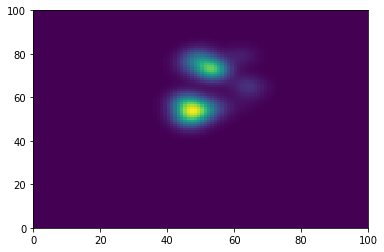

In [48]:
plt.pcolormesh(pdf_filter[0,-1,0,:,:])

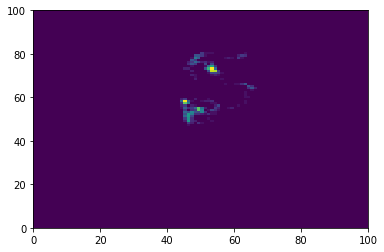

In [49]:
plt.pcolormesh(pdf[0,-1,0,:,:])

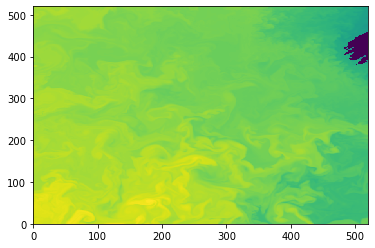

In [50]:
plt.pcolormesh(temperature[0,0,:,:])

In [7]:
(temperature,vorticity,u,v,ssh) = load_raw_images()

In [8]:
pdf = load_pdf()


In [9]:
temperature.shape

(324, 4, 520, 520)

In [10]:
pdf.shape

(321, 8, 36, 100, 100)